In [306]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [307]:
marketing = pd.read_csv('Cust_Records.csv')
marketing.columns

Index(['Age', 'Education', 'Relationship_Status', 'Income', 'Children',
       'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)',
       'Gold_Products ($)', 'Discount_Purchases', 'Web_Purchases',
       'Catalog_Purchases', 'Store_Purchases', 'Days_Enrolled',
       'Avg_Purch_Freq', 'Avg_Spend ($)', 'Accept_One', 'Accept_Rate',
       'Cust_Accept (%)'],
      dtype='object')

In [308]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2227 entries, 0 to 2226
Data columns (total 21 columns):
Age                    2227 non-null int64
Education              2227 non-null object
Relationship_Status    2227 non-null object
Income                 2227 non-null float64
Children               2227 non-null int64
Wine ($)               2227 non-null int64
Fruit ($)              2227 non-null int64
Meat ($)               2227 non-null int64
Fish ($)               2227 non-null int64
Sweets ($)             2227 non-null int64
Gold_Products ($)      2227 non-null int64
Discount_Purchases     2227 non-null int64
Web_Purchases          2227 non-null int64
Catalog_Purchases      2227 non-null int64
Store_Purchases        2227 non-null int64
Days_Enrolled          2227 non-null float64
Avg_Purch_Freq         2227 non-null float64
Avg_Spend ($)          2227 non-null float64
Accept_One             2227 non-null int64
Accept_Rate            2227 non-null object
Cust_Accept (%)       

*Preprocessing for Customer Segmentation / Classification / Regression Below*

In [309]:
from sklearn.preprocessing import StandardScaler
from scipy import stats

marketing_ml = marketing.drop(['Accept_One', 'Accept_Rate', 'Cust_Accept (%)'], axis=1)

## Unskewing Data with Log(1 + x) transform ###
unskewed = marketing_ml[['Age', 'Income', 'Children',
       'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)',
       'Gold_Products ($)', 'Discount_Purchases', 'Web_Purchases',
       'Catalog_Purchases', 'Store_Purchases', 'Days_Enrolled',
       'Avg_Purch_Freq', 'Avg_Spend ($)']]
unskewed = np.log1p(unskewed)
unskewed = pd.DataFrame(unskewed)

### Scaling Numerical Features ###
scaler = StandardScaler()
numerical = scaler.fit_transform(unskewed)
numerical = pd.DataFrame(numerical)

### Numerically Encoding Categorical Features ###
categorical = pd.get_dummies(data=marketing_ml, columns=['Education', 'Relationship_Status'], drop_first=False)

### Appending the categorical features to end on unskewed DF ###
ml = numerical.join(categorical[['Education_2n Cycle', 'Education_Basic', 'Education_Graduation',
       'Education_Master', 'Education_PhD', 'Relationship_Status_Divorced',
       'Relationship_Status_In-Relationship', 'Relationship_Status_Married',
       'Relationship_Status_Single', 'Relationship_Status_Widow']])

Text(0.5, 1.0, 'Elbow Plot')

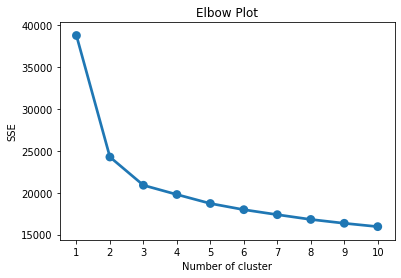

In [310]:
from sklearn.cluster import KMeans
import seaborn as sns

X = ml
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=27)
    kmeans.fit(X)
    sse[k] = kmeans.inertia_
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.title('Elbow Plot')

In [311]:
kmeans = KMeans(n_clusters = 3)
kmeans.fit(ml)
labels = kmeans.labels_
marketing['Cluster'] = labels
print('Cluster Counts')
print(marketing['Cluster'].value_counts())
print('\nNumerical Data - Grouped by Cluster (Means)')
marketing.groupby('Cluster').mean()

Cluster Counts
2    853
0    721
1    653
Name: Cluster, dtype: int64

Numerical Data - Grouped by Cluster (Means)


,Age,Income,Children,Wine ($),Fruit ($),Meat ($),Fish ($),Sweets ($),Gold_Products ($),Discount_Purchases,Web_Purchases,Catalog_Purchases,Store_Purchases,Days_Enrolled,Avg_Purch_Freq,Avg_Spend ($),Accept_One,Cust_Accept (%)
Cluster,,,,,,,,,,,,,,,,,,
0,45.950069,72680.043829,0.316227,588.891817,64.016644,395.135922,92.621359,65.061026,76.689320,1.445215,5.453537,5.485437,8.470180,473.564494,23.915394,63.543838,0.427184,13.869626
1,48.434916,53932.429442,1.269525,356.552833,14.297090,107.611026,19.229709,14.952527,48.857580,3.943338,5.543645,2.491577,6.641654,473.707504,27.390648,28.667020,0.280245,6.533946
2,41.783118,32789.066114,1.245018,24.318875,3.720985,18.848769,5.234467,4.490035,12.906213,1.841735,1.839390,0.424385,2.909730,481.307151,77.834633,9.415135,0.132474,2.735444


We see that one particular group had 43% of customers accept the offer at least once while also containing an average customer acceptance percentage of 14%. 

The next most promising group had 28% of customers accept the offer at least once while also containing an average customer acceptance percentage of 7%.

Least promising group had 13% of customers accept the offer at least once while also containing an average customer acceptance percentage of 3%. 

**Classification - 1)Predict Acceptance of one offer  2) Predict Acceptance Rate**

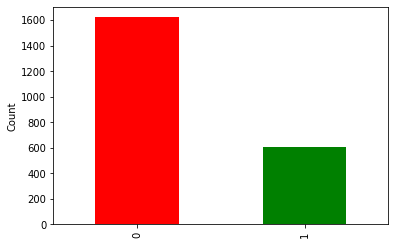

0    1623
1     604
Name: Accept_One, dtype: int64


In [312]:
### Imbalanced Classification Targets ###
my_colors = ['red', 'green']
marketing['Accept_One'].value_counts().plot(kind='bar', color=my_colors)
plt.ylabel('Count')
plt.show()
print(marketing['Accept_One'].value_counts())

In [313]:
### RandomForest - no imbalancing techniques ###
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score, make_scorer

f1_scorer = make_scorer(f1_score)

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

def plot_fi(fi): 
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

X = ml.values
y = marketing['Accept_One'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)
# clf = RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=27)
# grid_search = GridSearchCV(clf, 
#                            param_grid={
#                                        "n_estimators": [100, 200, 400, 600],
#                                        "min_samples_leaf": [3, 2, 1, .5, .1],
#                                        "max_features": ['sqrt', 'log2', .5, None]
#                                        },
#                            n_jobs=-1, scoring=f1_scorer,
#                            cv=5,
#                            iid=False, # just return the average score across folds
#                            return_train_score=False)
# grid_search.fit(X_train, y_train)
# best_clf = grid_search.best_estimator_
# y_pred_test = best_clf.predict(X_test)
# fi = rf_feat_importance(best_clf, categorical)
# # for feature in ['Education', 'Relationship_Status', 'Purchases', '($)']:
# #     print('\n', '*Most Important', feature, 'Category*' )
# #     new = fi.loc[fi['cols'].str.contains(feature)]
# #     print(new.sort_values('imp', ascending=False).head(1).to_string(index=False))

# plot_fi(fi)
# plt.show()

# print('\nOOB Score: ', best_clf.oob_score_)
# print('\nBest Params:', grid_search.best_params_)
# print('\nTesting Accuracy:', best_clf.score(X_test, y_test))
# print(classification_report(y_test, y_pred_test))
# print(confusion_matrix(y_test, y_pred_test))
# false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
# roc_auc = auc(false_positive_rate, true_positive_rate)
# print('\nROC_AUC: ', roc_auc)

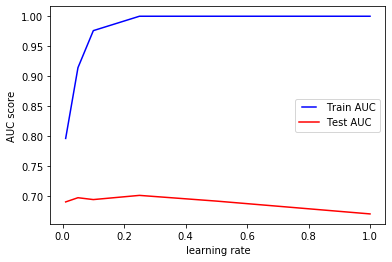

In [14]:
### Tuning Learning Rate ###
from xgboost import XGBClassifier

learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
train_results = []
test_results = []
for eta in learning_rates:
    model = XGBClassifier(learning_rate=eta)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(learning_rates, train_results, 'b', label='Train AUC')
line2, = plt.plot(learning_rates, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('learning rate')
plt.show()

Looks like learning rate of 0.25 is optimal 

**Summary of XBG Hyperparameter tuning steps I took**

[15:09:50] WARNING: C:\Users\Rachid\xgboost\src\learner.cc:480: 
Parameters: { max_features, min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




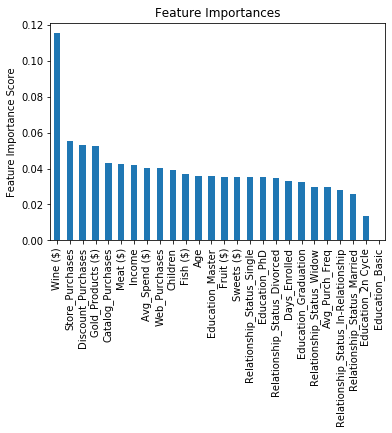


Testing Accuracy: 0.7989228007181328
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       399
           1       0.69      0.52      0.59       158

    accuracy                           0.80       557
   macro avg       0.76      0.71      0.73       557
weighted avg       0.79      0.80      0.79       557

[[363  36]
 [ 76  82]]

ROC_AUC:  0.7143808889311887


In [18]:
xgb = XGBClassifier(learning_rate=.25, n_estimators=45, subsample=.8, max_features='sqrt', max_depth=5, min_samples_split=.85,
                    min_samples_leaf=25,random_state=27)
xgb.fit(X_train, y_train)
y_pred_test = xgb.predict(X_test)
feat_imp = pd.Series(xgb.feature_importances_, categorical.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()
print('\nTesting Accuracy:', xgb.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nROC_AUC: ', roc_auc)

**----Undersampling----**

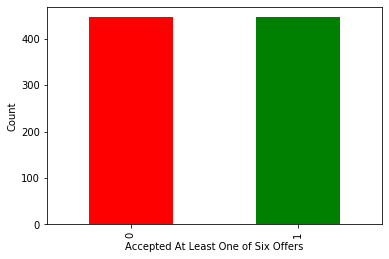

Acceptance Value Counts
1    446
0    446
dtype: int64


In [26]:
### Undersampling ###
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
acceptance = pd.Series(y_resampled)
acceptance.value_counts().reset_index(drop=True).plot(kind='bar', color=my_colors)
plt.xlabel('Accepted At Least One of Six Offers')
plt.ylabel('Count')
plt.xticks([0, 1])
plt.show()
print('Acceptance Value Counts')
print(acceptance.value_counts())


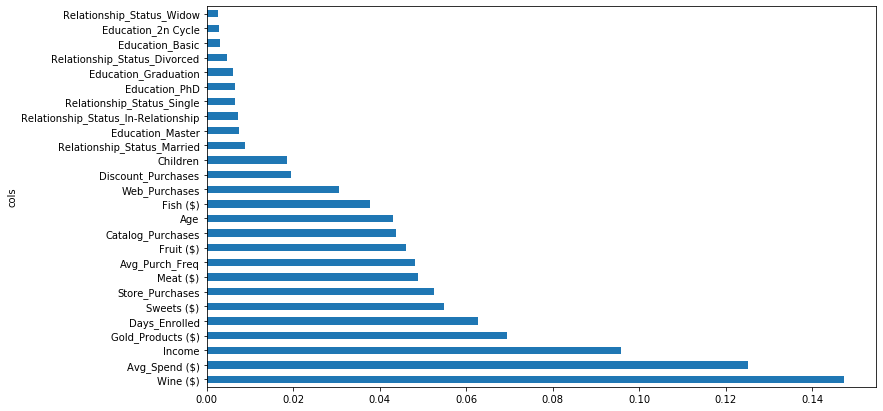


OOB Score:  0.7544843049327354

Best Params: {'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 100}

Testing Accuracy: 0.7522441651705566
              precision    recall  f1-score   support

           0       0.88      0.75      0.81       399
           1       0.55      0.75      0.63       158

    accuracy                           0.75       557
   macro avg       0.71      0.75      0.72       557
weighted avg       0.79      0.75      0.76       557

[[301  98]
 [ 40 118]]

ROC_AUC:  0.7506107039751276


In [93]:
### Random Forest Classifier Using Undersampling ###
clf = RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=27)
grid_search = GridSearchCV(clf, 
                           param_grid={
                                       "n_estimators": [100, 200, 400, 600],
                                       "min_samples_leaf": [3, 2, 1, .5, .1],
                                       "max_features": ['sqrt', 'log2', .5, None]
                                       },
                           n_jobs=-1, scoring=f1_scorer,
                           cv=4,
                           iid=False, # just return the average score across folds
                           return_train_score=False)
grid_search.fit(X_resampled, y_resampled)
best_clf = grid_search.best_estimator_
y_pred_test = best_clf.predict(X_test)
fi = rf_feat_importance(best_clf, categorical)
# for feature in ['Education', 'Relationship_Status', 'Purchases', '($)']:
#     print('\n', '*Most Important', feature, 'Category*' )
#     new = fi.loc[fi['cols'].str.contains(feature)]
#     print(new.sort_values('imp', ascending=False).head(1).to_string(index=False))

plot_fi(fi)
plt.show()

print('\nOOB Score: ', best_clf.oob_score_)
print('\nBest Params:', grid_search.best_params_)
print('\nTesting Accuracy:', best_clf.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nROC_AUC: ', roc_auc)

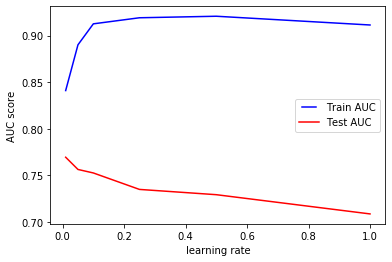

In [49]:
### Tuning Learning Rate ###
from xgboost import XGBClassifier

learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
train_results = []
test_results = []
for eta in learning_rates:
    model = XGBClassifier(learning_rate=eta)
    model.fit(X_resampled, y_resampled)
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(learning_rates, train_results, 'b', label='Train AUC')
line2, = plt.plot(learning_rates, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('learning rate')
plt.show()

~ .1 looks good

In [103]:
params = {'learning_rate': [.05, .75, .1, .125, .15, .175, .2],
          'n_estimators':[65, 70, 75, 80, 85, 90, 95]}
xgb = XGBClassifier(max_depth=5, min_samples_split=.894, subsample=.6, max_features='sqrt',
                    min_samples_leaf=25,random_state=27)
rand_search = RandomizedSearchCV(xgb, param_distributions = params, scoring=f1_scorer,
                    n_jobs=4,iid=False, cv=4, n_iter=50)
rand_search.fit(X_resampled, y_resampled)
print(rand_search.best_params_, rand_search.best_score_)

[19:45:51] WARNING: C:\Users\Rachid\xgboost\src\learner.cc:480: 
Parameters: { max_features, min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


{'n_estimators': 80, 'learning_rate': 0.15} 0.7586679726286243


[19:46:39] WARNING: C:\Users\Rachid\xgboost\src\learner.cc:480: 
Parameters: { max_features, min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




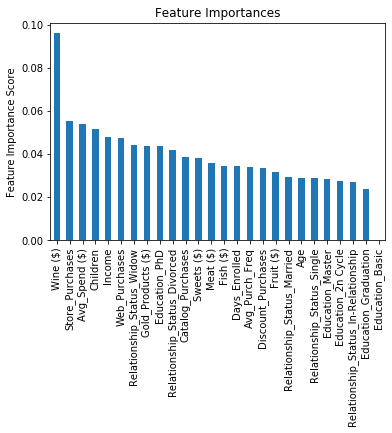


Testing Accuracy: 0.748653500897666
              precision    recall  f1-score   support

           0       0.89      0.74      0.81       399
           1       0.54      0.77      0.63       158

    accuracy                           0.75       557
   macro avg       0.71      0.75      0.72       557
weighted avg       0.79      0.75      0.76       557

[[296 103]
 [ 37 121]]

ROC_AUC:  0.7538387107008027


In [104]:
### Gradient Boost Classifier Using Undersampling ###

xgb = XGBClassifier(learning_rate=.15, n_estimators=80, subsample=.6, max_features='sqrt', max_depth=5, min_samples_split=.894,
                    min_samples_leaf=25,random_state=27)
xgb.fit(X_resampled, y_resampled)
y_pred_test = xgb.predict(X_test)
feat_imp = pd.Series(xgb.feature_importances_, categorical.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()
print('\nTesting Accuracy:', xgb.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nROC_AUC: ', roc_auc)


**----Oversampling----**

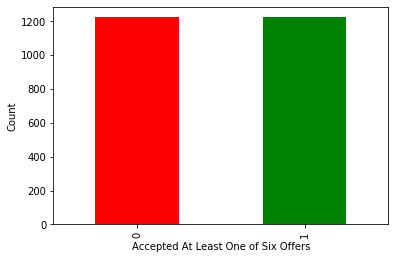

1    1224
0    1224
dtype: int64


In [314]:
### Oversampling ###
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority', n_jobs=-1)
X_sm, y_sm = smote.fit_resample(X_train, y_train)
acceptance = pd.Series(y_sm)
acceptance.value_counts().reset_index(drop=True).plot(kind='bar', color=my_colors)
plt.xlabel('Accepted At Least One of Six Offers')
plt.ylabel('Count')
plt.show()
print(acceptance.value_counts())

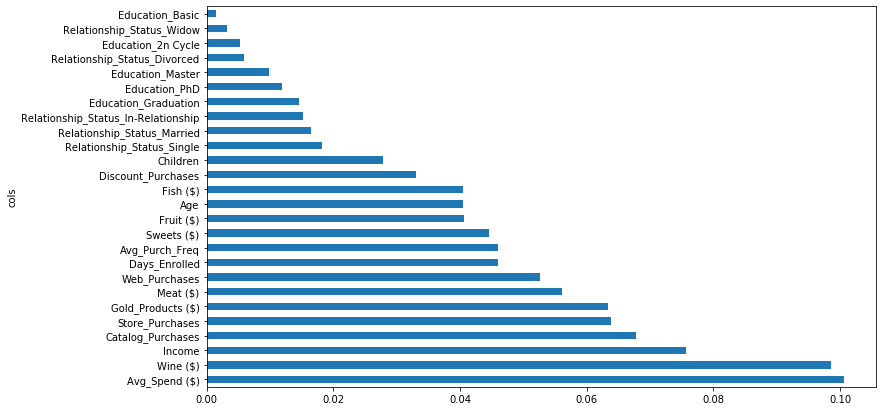


OOB Score:  0.8909313725490197

Best Params: {'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 600}

Testing Accuracy: 0.8132854578096947
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       399
           1       0.70      0.60      0.65       158

    accuracy                           0.81       557
   macro avg       0.77      0.75      0.76       557
weighted avg       0.81      0.81      0.81       557

[[358  41]
 [ 63  95]]

ROC_AUC:  0.7492544652771169


In [94]:
### Random Forest Classifier Using Oversampling ###
clf = RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=27)
grid_search = GridSearchCV(clf, 
                           param_grid={
                                       "n_estimators": [100, 200, 400, 600],
                                       "min_samples_leaf": [3, 2, 1, .5, .1],
                                       "max_features": ['sqrt', 'log2', .5, None]
                                       },
                           n_jobs=-1, scoring=f1_scorer,
                           cv=6,
                           iid=False, # just return the average score across folds
                           return_train_score=False)
grid_search.fit(X_sm, y_sm)
best_clf = grid_search.best_estimator_
y_pred_test = best_clf.predict(X_test)
fi = rf_feat_importance(best_clf, categorical)
# for feature in ['Education', 'Relationship_Status', 'Purchases', '($)']:
#     print('\n', '*Most Important', feature, 'Category*' )
#     new = fi.loc[fi['cols'].str.contains(feature)]
#     print(new.sort_values('imp', ascending=False).head(1).to_string(index=False))

plot_fi(fi)
plt.show()

print('\nOOB Score: ', best_clf.oob_score_)
print('\nBest Params:', grid_search.best_params_)
print('\nTesting Accuracy:', best_clf.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nROC_AUC: ', roc_auc)

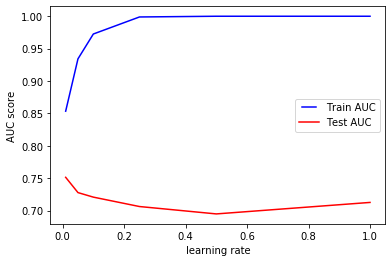

In [52]:
### Tuning Learning Rate ###
from xgboost import XGBClassifier

learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
train_results = []
test_results = []
for eta in learning_rates:
    model = XGBClassifier(learning_rate=eta)
    model.fit(X_sm, y_sm)
    train_pred = model.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(learning_rates, train_results, 'b', label='Train AUC')
line2, = plt.plot(learning_rates, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('learning rate')
plt.show()

~ .1 - .15 looks optimal

[20:04:58] WARNING: C:\Users\Rachid\xgboost\src\learner.cc:480: 
Parameters: { max_features, min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




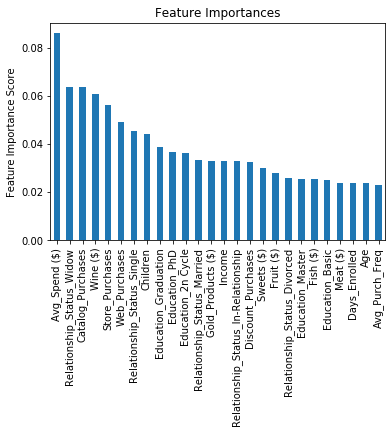


Testing Accuracy: 0.7989228007181328
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       399
           1       0.67      0.57      0.62       158

    accuracy                           0.80       557
   macro avg       0.76      0.73      0.74       557
weighted avg       0.79      0.80      0.79       557

[[355  44]
 [ 68  90]]

ROC_AUC:  0.7296722819707496


In [116]:
### Gradient Boost Classifier Using Oversampling ###

xgb = XGBClassifier(learning_rate=.1, n_estimators=85, subsample=.7, max_features='sqrt', max_depth=30, min_samples_split=.9197,
                    min_samples_leaf=50,random_state=27)
xgb.fit(X_sm, y_sm)
y_pred_test = xgb.predict(X_test)
feat_imp = pd.Series(xgb.feature_importances_, categorical.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()
print('\nTesting Accuracy:', xgb.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nROC_AUC: ', roc_auc)


In [315]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(5, activation='relu', input_dim=66))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_sm, y_sm, epochs=100)

ModuleNotFoundError: No module named 'keras'

**After classifying a customer as Accepted (1), classify their offer acceptance rate (indicates customers that are most likely to accept the offer each time it is sent out)**

Imbalanced Multiclass Problem


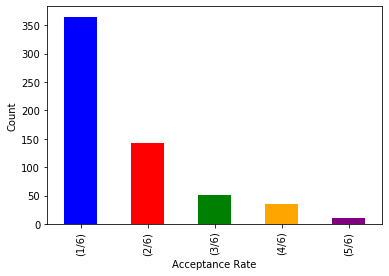

  Accept_Rate  # Customers  Percentage
0       (1/6)          365    0.604305
1       (2/6)          142    0.235099
2       (3/6)           51    0.084437
3       (4/6)           36    0.059603
4       (5/6)           10    0.016556


In [297]:
### Sclicing to only included customers who accepted at least one offer ###
marketing = pd.read_csv('Cust_Records.csv')
marketing_accept = marketing.loc[marketing['Accept_One'] == 1].reset_index(drop=True)

### Distribution of Those Who Accepted At Least One Offer ###
my_colors = ['blue', 'red', 'green', 'orange', 'purple']
new = marketing_accept.groupby('Accept_Rate')['Accept_One'].count().reset_index()
new['Percent'] = new['Accept_One'] / sum(new['Accept_One']) 
new.columns = ['Accept_Rate', '# Customers', 'Percentage']
print('Imbalanced Multiclass Problem')
marketing_accept.groupby('Accept_Rate')['Accept_Rate'].count().plot(kind='bar', color=my_colors)
plt.xlabel('Acceptance Rate')
plt.ylabel('Count')
plt.show()
print(new)


In [298]:
### Numerically Encode Accept_Rate ###
for idx, row in marketing_accept.iterrows():
    if row['Accept_Rate'] == '(1/6)':
        marketing_accept.loc[idx, 'Accept_Rate'] = 1
    elif row['Accept_Rate'] == '(2/6)':
        marketing_accept.loc[idx, 'Accept_Rate'] = 2
    elif row['Accept_Rate'] == '(3/6)':
        marketing_accept.loc[idx, 'Accept_Rate'] = 3
    elif row['Accept_Rate'] == '(4/6)':
        marketing_accept.loc[idx, 'Accept_Rate'] = 4
    elif row['Accept_Rate'] == '(5/6)':
        marketing_accept.loc[idx, 'Accept_Rate'] = 5

print(marketing_accept['Accept_Rate'])
marketing_ml_accept = marketing_accept.drop(['Accept_One', 'Accept_Rate', 'Cust_Accept (%)'], axis=1)

## Unskewing Data with Log(1 + x) transform ###
unskewed = marketing_ml_accept[['Age', 'Income', 'Children',
       'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)',
       'Gold_Products ($)', 'Discount_Purchases', 'Web_Purchases',
       'Catalog_Purchases', 'Store_Purchases', 'Days_Enrolled',
       'Avg_Purch_Freq', 'Avg_Spend ($)']]
unskewed = np.log1p(unskewed)
unskewed = pd.DataFrame(unskewed)

### Scaling Numerical Features ###
scaler = StandardScaler()
numerical = scaler.fit_transform(unskewed)
numerical = pd.DataFrame(numerical)
### Numerically Encoding Categorical Features ###
categorical = pd.get_dummies(data=marketing_ml_accept, columns=['Education', 'Relationship_Status'], drop_first=False)
### Appending the categorical features to end on unskewed DF ###
ml_accept = numerical.join(categorical[['Education_2n Cycle', 'Education_Basic', 'Education_Graduation',
       'Education_Master', 'Education_PhD', 'Relationship_Status_Divorced',
       'Relationship_Status_In-Relationship', 'Relationship_Status_Married',
       'Relationship_Status_Single', 'Relationship_Status_Widow']], how='right')

0      1
1      1
2      1
3      3
4      1
      ..
599    1
600    1
601    3
602    1
603    1
Name: Accept_Rate, Length: 604, dtype: int64


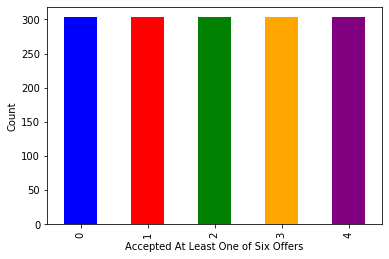

5    303
4    303
3    303
2    303
1    303
dtype: int64


In [299]:
### Classifier for Accept_Rate - Gradient Boosting ###
from sklearn.multiclass import OneVsRestClassifier

new['Weights'] = new.loc[4, 'Percentage'] / new['Percentage']

X = ml_accept.values
y = marketing_accept['Accept_Rate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.175, random_state=42)
y_traindf = pd.DataFrame(y_train)
y_traindf['weights'] = 0
for idx, row in y_traindf.iterrows():
    if row['Accept_Rate'] == 1:
        y_traindf.loc[idx, 'weights'] = new.loc[0, 'Weights']
    elif row['Accept_Rate'] == 2:
        y_traindf.loc[idx, 'weights'] = new.loc[1, 'Weights']
    elif row['Accept_Rate'] == 3:
        y_traindf.loc[idx, 'weights'] = new.loc[2, 'Weights']
    elif row['Accept_Rate'] == 4:
        y_traindf.loc[idx, 'weights'] = new.loc[3, 'Weights']
    elif row['Accept_Rate'] == 5:
        y_traindf.loc[idx, 'weights'] = new.loc[4, 'Weights']
y_train = y_traindf['Accept_Rate']

### Weight for Gradient Boosting ###
weights = y_traindf['weights']

### SMOTE ###
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_sm, y_sm = sm.fit_resample(X_train, y_train)
acceptance = pd.Series(y_sm)
acceptance.value_counts().reset_index(drop=True).plot(kind='bar', color=my_colors)
plt.xlabel('Accepted At Least One of Six Offers')
plt.ylabel('Count')
plt.show()
print(acceptance.value_counts())

[17:33:58] WARNING: C:\Users\Rachid\xgboost\src\learner.cc:480: 
Parameters: { weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




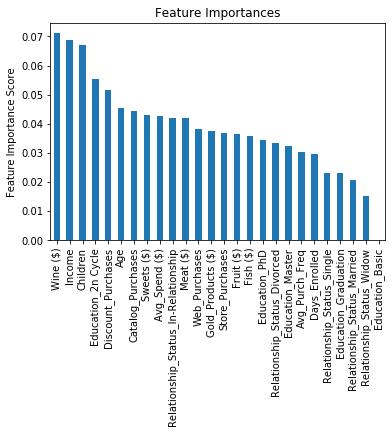


Testing Accuracy: 0.6698113207547169
              precision    recall  f1-score   support

           1       0.74      0.85      0.79        62
           2       0.52      0.44      0.48        25
           3       0.50      0.30      0.37        10
           4       0.50      0.50      0.50         6
           5       1.00      0.33      0.50         3

    accuracy                           0.67       106
   macro avg       0.65      0.49      0.53       106
weighted avg       0.66      0.67      0.65       106

[[53  8  1  0  0]
 [11 11  1  2  0]
 [ 6  1  3  0  0]
 [ 2  0  1  3  0]
 [ 0  1  0  1  1]]
[17:33:58] WARNING: C:\Users\Rachid\xgboost\src\learner.cc:480: 
Parameters: { weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




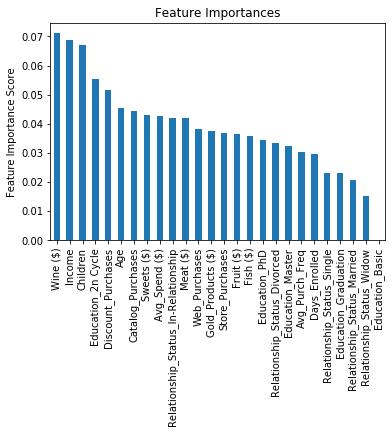


Testing Accuracy: 0.6698113207547169
              precision    recall  f1-score   support

           1       0.74      0.85      0.79        62
           2       0.52      0.44      0.48        25
           3       0.50      0.30      0.37        10
           4       0.50      0.50      0.50         6
           5       1.00      0.33      0.50         3

    accuracy                           0.67       106
   macro avg       0.65      0.49      0.53       106
weighted avg       0.66      0.67      0.65       106

[[53  8  1  0  0]
 [11 11  1  2  0]
 [ 6  1  3  0  0]
 [ 2  0  1  3  0]
 [ 0  1  0  1  1]]


In [301]:
### Gradient Boosting Accepted_one ###
xgb = XGBClassifier(weight = y_traindf['weights'])
xgb.fit(X_train, y_train)
y_pred_test = xgb.predict(X_test)
feat_imp = pd.Series(xgb.feature_importances_, categorical.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()
print('\nTesting Accuracy:', xgb.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))

xgb = XGBClassifier(weight='balanced')
xgb.fit(X_train, y_train)
y_pred_test = xgb.predict(X_test)
feat_imp = pd.Series(xgb.feature_importances_, categorical.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()
print('\nTesting Accuracy:', xgb.score(X_test, y_test))
print(classification_report(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))